In [71]:
import csv
import os
from pathlib import Path
import librosa
import matplotlib.pyplot as plt
import numpy as np
import json
import torch
from torch import nn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import skorch
import math
import torchviz

In [72]:
torch.manual_seed(123456789)

labels = [
    'blues', 'classical', 'country', 'disco', 'hiphop', 
    'jazz', 'metal', 'pop', 'reggae', 'rock'
]

base_path = Path("Data/genres_original")
data_path = Path("Data/mfcc.json")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## First Attempt

I read from [This article](https://athina-b.medium.com/audio-signal-feature-extraction-for-analysis-507861717dc1) that Mel-Frequency Cepstral Coefficients (MFCC) are the most common audi feature extraction technique.

I also noticed, that the pre-extracted features include MFCC variances as a component of the extracted features, but I wanted to see how effective it was to use the actual MFCC data instead of the variances.

This extraction technique is based on one I found on [Kaggle](https://www.kaggle.com/code/dapy15/music-genre-classification).

Something important to note about this approach is that it extracts the MFCC in segments, rather than for the entire audio track. This can result in way more data points than you'd get by just extracting once for each track.

**Note**: I based the extraction of the data on the above link, but I did not reference the architecture designs

In [73]:

def extract_data(
    input_path: Path, 
    output_path: Path, 
    *,
    segments: int = 10,
    sample_rate: int = 22050,
    n_mfcc: int = 20, 
    n_fft: int = 2048, 
    hop_length: int = 512, 
):
    features = []
    targets = []

    samples_per_seg = int((sample_rate * 30) / segments)
    seg_len = math.ceil(samples_per_seg / hop_length)

    for path in input_path.glob("*/*.wav"):
        if path.name == "jazz.00054.wav":
            # librosa can't read files > 1MB
            continue

        genre = path.parent.stem
        y, sr = librosa.load(path, sr=sample_rate)

        label = labels.index(genre)

        for seg in range(segments):
            start = samples_per_seg * seg
            end = start + samples_per_seg

            mfcc = librosa.feature.mfcc(
                y=y[start:end], 
                sr=sr,
                n_fft=n_fft,
                n_mfcc=n_mfcc,
                hop_length=hop_length,
            ).T

            # I'm not super clear as to why, but some of 
            # the mfcc's are slightly larger than the rest
            # so we discard them
            if len(mfcc) == seg_len:
                features.append(mfcc.tolist())
                targets.append(label)
    
    with open(output_path, "w") as f:
        json.dump({'mfcc': features, 'labels': targets}, f)


# extract_data(base_path, data_path)

In [104]:
def load_data(path):
    with open(path, 'r') as f:
        data = json.load(f)
    
    sizes = {}
    for mfcc in data["mfcc"]:
        length = len(mfcc)
        sizes.setdefault(length, 0)
        sizes[length] += 1


    return data["mfcc"], data["labels"]

inputs, targets = load_data(data_path)
inputs = torch.tensor(inputs, dtype=torch.float32)
targets = torch.tensor(targets)

X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2)


I wanted to try the same approach we used in the first couple of problems, so I lifted the network implmentation
from there

In [5]:
X_train_l = torch.flatten(X_train, 1)
X_test_l = torch.flatten(X_test, 1)

class Network(nn.Module):
    def __init__(self, in_features: int, out_features: int, dropout: float = 0.5):
        super().__init__()

        self.l1 = nn.Sequential(
            nn.Linear(in_features, l1_features := 512),
            nn.BatchNorm1d(l1_features),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.l2 = nn.Sequential(
            nn.Linear(l1_features, l2_features := 256),
            nn.BatchNorm1d(l2_features),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.l3 = nn.Sequential(
            nn.Linear(l2_features, l3_features := 64),
            nn.BatchNorm1d(l3_features),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.l4 = nn.Sequential(
            nn.Linear(l3_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.Softmax(1)
        )


    def forward(self, x):
        output = self.l1(x)
        output = self.l2(output)
        output = self.l3(output)
        output = self.l4(output)
        return output
        

Using the parameters for this network that we used for problem #2 gave me better results than I was expecting at around 62% the SVM baseline performs around 58% so there is a difference, even if it's not a dramatic one

I performed a grid search, but it turned out that the paramters used on the previous problems were the most effective. 

In [7]:
lin_classifier = skorch.NeuralNetClassifier(
    module=Network,
    module__in_features=X_train_l.shape[1],
    module__out_features=10,
    module__dropout=0.5,
      # Criterion
    criterion=nn.CrossEntropyLoss,
    criterion__reduction='mean',
    # Optimizer
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=0.002,
    lr=0.0001,
    # Training
    max_epochs=35,
    batch_size=64,
    # Misc
    verbose=1,
    device=device,
)

lin_classifier.fit(X_train_l, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2560       0.3617        2.2084  3.3068
      2        2.2108       0.4043        2.1714  0.8349
      3        2.1801       0.4424        2.1498  0.8365
      4        2.1588       0.4631        2.1321  0.8322
      5        2.1473       0.5181        2.1200  0.8260
      6        2.1305       0.5213        2.1031  0.8295
      7        2.1205       0.5382        2.0978  0.8769
      8        2.1084       0.5469        2.0856  0.8277
      9        2.1000       0.5582        2.0774  0.8247
     10        2.0874       0.5588        2.0730  0.7705
     11        2.0774       0.5695        2.0700  0.7651
     12        2.0659       0.5695        2.0574  0.7540
     13        2.0607       0.5738        2.0550  0.7644
     14        2.0484       0.5657        2.0463  0.7633
     15        2.0391       0.5713        2.0456  0.8663
     16        2.0278       0.5

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Network(
    (l1): Sequential(
      (0): Linear(in_features=2600, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
    )
    (l2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
    )
    (l3): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
    )
    (l4): Sequential(
      (0): Linear(in_features=64, out_features=10, bias=True)
      (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Softm

In [9]:
pred = lin_classifier.predict(X_test_l)
print(accuracy_score(y_test, pred))


0.6096096096096096


In [10]:
# Reshaped for input into a CNN
X_train_c = torch.reshape(X_train, (-1, 20, 130))
X_test_c = torch.reshape(X_test, (-1, 20, 130))


class CNN(nn.Module):
    def __init__(self, dropout: int = 0.4):
        super().__init__()
        self.convolute = nn.Sequential(
            nn.Conv1d(20, 64, kernel_size=3),
            nn.MaxPool1d(2, 2),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=3),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(32, 16, kernel_size=3),
            nn.MaxPool1d(2, 2),
        )

        self.linear = nn.Sequential(
            nn.Linear(224, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        out = self.convolute(x)
        out = torch.reshape(out, (-1, 224))
        out = self.linear(out)
        out = torch.softmax(out, 1)
        return out

In [11]:
cnn_classifier = skorch.NeuralNetClassifier(
    module=CNN,
    module__dropout=0.4,
      # Criterion
    criterion=nn.CrossEntropyLoss,
    criterion__reduction='mean',
    # Optimizer
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=0.002,
    lr=0.001,
    # Training
    max_epochs=50,
    batch_size=128,
    # Misc
    verbose=1,
    device=device,
)

cnn_classifier.fit(X_train_c, y_train)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        2.2075       0.3479        2.1113  20.9074
      2        2.0978       0.3642        2.0888  1.2075
      3        2.0699       0.3917        2.0595  1.2020
      4        2.0415       0.4174        2.0361  1.1984
      5        2.0300       0.4412        2.0162  1.1865
      6        2.0166       0.4205        2.0330  1.1879
      7        2.0024       0.4756        1.9776  1.1834
      8        2.0016       0.4305        2.0203  1.1751
      9        2.0168       0.4625        1.9914  1.2043
     10        1.9891       0.4844        1.9701  1.2015
     11        1.9752       0.4812        1.9779  1.2076
     12        1.9826       0.4731        1.9815  1.2024
     13        1.9781       0.4812        1.9742  1.2000
     14        1.9579       0.4850        1.9719  1.2005
     15        1.9520       0.4862        1.9749  1.1988
     16        1.9441       

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=CNN(
    (convolute): Sequential(
      (0): Conv1d(20, 64, kernel_size=(3,), stride=(1,))
      (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
      (3): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
      (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv1d(32, 16, kernel_size=(3,), stride=(1,))
      (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (linear): Sequential(
      (0): Linear(in_features=224, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.4, inplace=False)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.4, inplace=False)
      (6): Linear(in_features=64, out_features=10, bias=True)
    )
  ),
)

In [12]:
pred = cnn_classifier.predict(X_test_c)
print(accuracy_score(y_test, pred))

0.5640640640640641


And finally, also tried out an LSTM, which did result in improved performance over either of the others

In [105]:
X_train_lstm = torch.reshape(X_train, (-1, 20, 130))
X_test_lstm = torch.reshape(X_test, (-1, 20, 130))

class LSTM(nn.Module):
    def __init__(self, in_features: int, out_features: int, dropout: int):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=in_features,
            hidden_size=64,
            num_layers=3,
            batch_first=True,
            dropout=dropout,
        )

        self.l1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1280, out_features),
        )

    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.l1(output)
        return output


lstm_classifier = skorch.NeuralNetClassifier(
    module=LSTM,
    module__in_features=X_train_lstm.shape[2],
    module__out_features=10,
    module__dropout=0.4,
    # Criterion
    criterion=nn.CrossEntropyLoss,
    # Optimizer
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=0.001,
    lr=0.001,
    # Training
    max_epochs=50,
    batch_size=256,
    # Misc
    verbose=1,
    device=device,
)

lstm_classifier.fit(X_train_lstm, y_train)

pred = lstm_classifier.predict(X_test_lstm)
print(accuracy_score(y_test, pred))

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0714       0.3773        1.7385  0.5046
      2        1.5870       0.4556        1.4501  0.3415
      3        1.4150       0.5038        1.3645  0.3799
      4        1.3086       0.5482        1.2501  0.3580
      5        1.2110       0.5663        1.1899  0.3403
      6        1.1547       0.5776        1.1526  0.3528
      7        1.1062       0.5857        1.1244  0.3521
      8        1.0594       0.6120        1.1200  0.3607
      9        1.0225       0.6170        1.0779  0.3598
     10        0.9834       0.6258        1.0603  0.3545
     11        0.9429       0.6395        1.0401  0.3513
     12        0.9077       0.6514        1.0251  0.3596
     13        0.8902       0.6558        1.0084  0.3544
     14        0.8674       0.6564        1.0059  0.3697
     15        0.8405       0.6589        0.9927  0.3647
     16        0.8008       0.6

# Second Approach

I wasn't having much luck with just MFCC, so I decided to pull a few more features and see what sort of accuracy they could provide 

I pulled the mean, minimum, and max for:
- MFCC
- Melspectogram
- Chroma Vector
- Tonnetz




In [14]:
features_path = Path("Data/features.csv")

def extract_features(file: Path):
    y, sr = librosa.load(file)

    mfcc = np.array(librosa.feature.mfcc(y=y, sr=sr))
    melspectrogram = np.array(librosa.feature.melspectrogram(y=y, sr=sr))
    chroma = np.array(librosa.feature.chroma_stft(y=y, sr=sr))
    tonnetz = np.array(librosa.feature.tonnetz(y=y, sr=sr))

    return np.concatenate([
        mfcc.mean(axis=1),
        mfcc.min(axis=1),
        mfcc.max(axis=1),
        melspectrogram.mean(axis=1),
        melspectrogram.min(axis=1),
        melspectrogram.max(axis=1),
        chroma.mean(axis=1),
        chroma.min(axis=1),
        chroma.max(axis=1),
        tonnetz.mean(axis=1),
        tonnetz.min(axis=1),
        tonnetz.max(axis=1),
    ])


def create_dataset(input_path: Path, output_path: Path):   
    with open(output_path, "w", newline='') as file:
        writer = csv.writer(file)
        for path in input_path.glob("*/*.wav"):
            if path.name == "jazz.00054.wav":
            # librosa can't read files > 1MB
                continue
            
            features = extract_features(path)
            labeled_features = np.concatenate((np.array([path.parent.stem]), features))
            writer.writerow(labeled_features)


# create_dataset(base_path, features_path)

In [101]:
def load_data(path: Path):
    with open(path) as f: 
        data = np.loadtxt(f, delimiter=',', dtype=np.object_)

    inputs, targets = data[:, 1:].astype(np.float32), data[:, 0]
    
    min_max_scaler = preprocessing.MinMaxScaler((-1, 1))
    inputs = min_max_scaler.fit_transform(inputs)
    inputs = torch.tensor(inputs)
    targets = torch.tensor(np.fromiter((labels.index(target) for target in targets), dtype=np.int32), dtype=torch.long)

    return inputs, targets

X, y = load_data(features_path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Again, this uses basically the same network as the first two problems. When comparing against an SVM who performs at about 64% we can see the NN approach performs quite a bit better at 74%

In [16]:

class Network2(nn.Module):
    def __init__(self, in_features: int, out_features: int, dropout: float = 0.5):
        super().__init__()

        self.l1 = nn.Sequential(
            nn.Linear(in_features, l1_features := 512),
            nn.BatchNorm1d(l1_features),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.l2 = nn.Sequential(
            nn.Linear(l1_features, l2_features := 256),
            nn.BatchNorm1d(l2_features),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.l3 = nn.Sequential(
            nn.Linear(l2_features, l3_features := 64),
            nn.BatchNorm1d(l3_features),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.l4 = nn.Sequential(
            nn.Linear(l3_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.Softmax(1)
        )


    def forward(self, x):
        output = self.l1(x)
        output = self.l2(output)
        output = self.l3(output)
        output = self.l4(output)
        return output
       

In [102]:
# A base line to target
from sklearn.svm import SVC

svm = SVC()

svm.fit(X_train, y_train)
multi_svm_score = svm.score(X_test, y_test)
print(multi_svm_score)

0.645


In [79]:
multi_classifier = skorch.NeuralNetClassifier(
    module=Network2,
    module__in_features=X_train.shape[1],
    module__out_features=10,
    module__dropout=0.1,
    # Criterion
    criterion=nn.CrossEntropyLoss,
    criterion__reduction='mean',
    # Optimizer
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=0.002,
    lr=0.0001,
    # Training
    max_epochs=50,
    batch_size=128,
    # Misc
    verbose=1,
    device=device,
)


multi_classifier.fit(X_train, y_train)

predictions = multi_classifier.predict(X_test)
print(accuracy_score(y_test, predictions))

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3068       0.1125        2.3024  0.1999
      2        2.2613       0.1812        2.3006  0.0878
      3        2.2077       0.2000        2.2952  0.0658
      4        2.1638       0.3438        2.2808  0.0608
      5        2.1211       0.4875        2.2547  0.0597
      6        2.1011       0.4875        2.2178  0.0528
      7        2.0719       0.5188        2.1802  0.0564
      8        2.0433       0.5687        2.1504  0.0578
      9        2.0315       0.6000        2.1293  0.0557
     10        2.0118       0.6000        2.1164  0.0564
     11        1.9915       0.6125        2.1055  0.0608
     12        1.9767       0.6062        2.0995  0.0633
     13        1.9725       0.6312        2.0863  0.0623
     14        1.9554       0.6438        2.0711  0.0613
     15        1.9417       0.6250        2.0625  0.0608
     16        1.9349       0.6

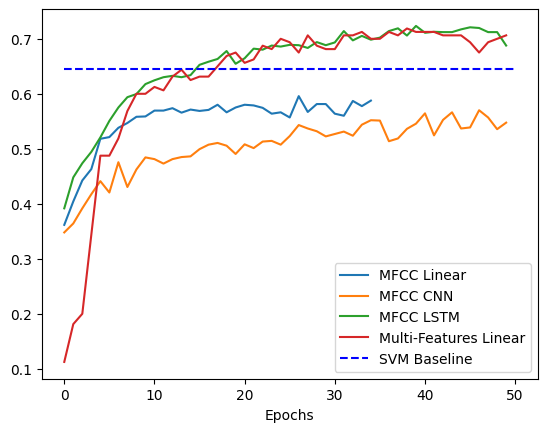

In [99]:
plt.plot(lin_classifier.history[:, 'valid_acc'], label='MFCC Linear')
plt.plot(cnn_classifier.history[:, 'valid_acc'], label='MFCC CNN')
plt.plot(lstm_classifier.history[:, 'valid_acc'], label='MFCC LSTM')
plt.plot(multi_classifier.history[:, 'valid_acc'], label='Multi-Features Linear')
plt.hlines(multi_svm_score, xmin=0, xmax=50, color="b", linestyles="dashed", label="SVM Baseline")
plt.legend()
plt.xlabel("Epochs")

plt.show()